In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import math
import time
import matplotlib
from scipy import linalg
import scipy.integrate as integrate
import scipy.special as special
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
%matplotlib inline

sns.set(style="darkgrid")

# Задача Коши

### Функция для отрисовки графиков

In [2]:
def draw(x0, xf, h, labels, *args):
    xs = np.arange(x0, xf, h)
    
    plt.figure(figsize=(20,8), dpi= 80)
    
    for (i, ys) in enumerate(args):
        print(len(xs), len(ys), xs[0], ys[0], xs[-1], ys[-1])
        plt.plot(xs, ys, label=labels[i], linewidth=1)
    
    plt.legend()
    plt.show()

### Численые методы решения обыкновенных дифферициальных уравнений

In [3]:
class Exact:
    def __init__(self, solved_equation, h):
        self.f = solved_equation
        self.h = h

    def _next_y(self, xi, yi):
        return self.f(xi)

    def calculate(self, x0, y0, xf):
        xs = np.arange(x0 + self.h, xf + self.h, self.h)
        y = y0
        ys = []
        for x in xs:
            ys.append(y)
            y = self._next_y(x, y)
            
        return ys

In [4]:
class Euler(Exact):
    def _next_y(self, xi, yi):
        return yi + self.h * self.f(xi, yi)

In [5]:
class RungeKutta_3a(Euler):
    def _next_y(self, xi, yi):
        h2 = self.h / 2
        k1 = self.f(xi, yi)
        k2 = self.f(xi + h2, yi + h2 * k1)
        k3 = self.f(xi + self.h, yi - self.h*k1 + 2*self.h*k2)
        return yi + (self.h / 6) * (k1 + 4*k2 + k3)

In [6]:
class RungeKutta_3b(Euler):
    def _next_y(self, xi, yi):
        h3 = self.h / 3
        k1 = self.f(xi, yi)
        k2 = self.f(xi + h3, yi + h3 * k1)
        k3 = self.f(xi + 2*h3, yi - 2*h3*k2)
        return yi + (self.h / 4) * (k1 + 3*k3)

In [7]:
class RungeKutta_4a(Euler):
    def _next_y(self, xi, yi):
        h2 = self.h / 2
        k1 = self.f(xi, yi)
        k2 = self.f(xi + h2, yi + h2 * k1)
        k3 = self.f(xi + h2, yi + h2 * k2)
        k4 = self.f(xi + self.h, yi + self.h * k3)
        return yi + (self.h / 6) * (k1 + 2 * k2 + 2 * k3 + k4)

In [8]:
class RungeKutta_4b(Euler):
    def _next_y(self, xi, yi):
        h2 = self.h / 2
        h4 = self.h / 4
        k1 = self.f(xi, yi)
        k2 = self.f(xi + h4, yi + h4 * k1)
        k3 = self.f(xi + h2, yi + h2 * k2)
        k4 = self.f(xi + self.h, yi - 2 * self.h * k2 + 2 * self.h * k3)
        return yi + (self.h / 6) * (k1 + 4*k3 + k4)

In [9]:
class Adams_2(Exact):
    def __init__(self, solved_equation, h, x0, y0, xf):
        self.f = solved_equation
        self.h = h
        self.step = 0
        
    def _next_y_euler(self, xi, yi):
        return yi + self.h * self.f(xi, yi)
    
    def _next_y(self, xi, yi, xt, yt):
        return yi + self.h * (3 * self.f(self.h * xt[1], yt[1]) - 1 * self.f(self.h * xt[0], yt[0])) / 2
    
    def calculate(self, x0, y0, xf):
        xs = np.arange(x0 + self.h, xf + self.h, self.h)
        y = y0
        ys = []
        step = 0
        xt = [0, 1]
        yt = [0, 0]
        for x in xs:
            ys.append(y)
            if step < 1:
                y = self._next_y_euler(x, y)
            else:
                y = self._next_y(x, y, xt, yt)
            
            for i in range(1, 2):
                yt[i - 1] = yt[i]
            yt[1] = y
            step += 1
            for i in range(1, 2):
                xt[i - 1] = xt[i]
            xt[1] = step
            
        return ys

In [10]:
class Adams_3(Exact):
    def __init__(self, solved_equation, h, x0, y0, xf):
        self.f = solved_equation
        self.h = h
        self.step = 0
        
    def _next_y_euler(self, xi, yi):
        return yi + self.h * self.f(xi, yi)
    
    def _next_y(self, xi, yi, xt, yt):
        return yi + self.h * (23 * self.f(self.h * xt[2], yt[2]) - 16 * self.f(self.h * xt[1], yt[1]) + 5 * self.f(self.h * xt[0], yt[0])) / 12
    
    def calculate(self, x0, y0, xf):
        xs = np.arange(x0 + self.h, xf + self.h, self.h)
        y = y0
        ys = []
        step = 0
        xt = [0, 1, 2]
        yt = [0, 0, 0]
        for x in xs:
            ys.append(y)
            if step < 2:
                y = self._next_y_euler(x, y)
            else:
                y = self._next_y(x, y, xt, yt)
                for i in range(1, 3):
                    yt[i - 1] = yt[i]
                yt[2] = y
                step += 1
                for i in range(1, 3):
                    xt[i - 1] = xt[i]
                xt[2] = step
                
        return ys

In [11]:
class Adams_4(Exact):
    def __init__(self, solved_equation, h, x0, y0, xf):
        self.f = solved_equation
        self.h = h
        self.step = 0
        
    def _next_y_euler(self, xi, yi):
        return yi + self.h * self.f(xi, yi)
    
    def _next_y(self, xi, yi, xt, yt):
        return yi + self.h * (55 * self.f(self.h * xt[3], yt[3]) - 59 * self.f(self.h * xt[2], yt[2]) 
                              + 37 * self.f(self.h * xt[1], yt[1]) - 5 * self.f(self.h * xt[0], yt[0])) / 720
    
    def calculate(self, x0, y0, xf):
        xs = np.arange(x0 + self.h, xf + self.h, self.h)
        y = y0
        ys = []
        step = 0
        xt = [0, 1, 2, 3]
        yt = [0, 0, 0, 0]
        for x in xs:
            ys.append(y)
            if step < 3:
                y = self._next_y_euler(x, y)
            else:
                y = self._next_y(x, y, xt, yt)
                for i in range(1, 4):
                    yt[i - 1] = yt[i]
                yt[3] = y
                step += 1
                for i in range(1, 4):
                    xt[i - 1] = xt[i]
                xt[3] = step
                
        return ys

In [12]:
class Adams_5(Exact):
    def __init__(self, solved_equation, h, x0, y0, xf):
        self.f = solved_equation
        self.h = h
        self.step = 0
        
    def _next_y_euler(self, xi, yi):
        return yi + self.h * self.f(xi, yi)
    
    def _next_y(self, xi, yi, xt, yt):
        return yi + self.h * (1901 * self.f(self.h * xt[4], yt[4]) - 2774 * self.f(self.h * xt[3], yt[3]) 
                              + 2616 * self.f(self.h * xt[1], yt[1]) - 1274 * self.f(self.h * xt[0], yt[0]) 
                                  + 251 * self.f(self.h * xt[0], yt[0])) / 720
    
    def calculate(self, x0, y0, xf):
        xs = np.arange(x0 + self.h, xf + self.h, self.h)
        y = y0
        ys = []
        step = 0
        xt = [0, 1, 2, 3, 4]
        yt = [0, 0, 0, 0, 0]
        for x in xs:
            ys.append(y)
            if step < 4:
                y = self._next_y_euler(x, y)
            else:
                y = self._next_y(x, y, xt, yt)
                for i in range(1, 5):
                    yt[i - 1] = yt[i]
                yt[4] = y
                step += 1
                for i in range(1, 5):
                    xt[i - 1] = xt[i]
                xt[4] = step
                
        return ys

### Решение

In [13]:
def equation(x, y):
    return x - y

In [14]:
def exact_sol(x):
    return x + 2*np.exp(-x) - 1

In [15]:
X0 = 0
Y0 = 1
XF = 1.3
N = 100
H = (XF - X0) / N
XF += H

In [16]:
x_cros = np.linspace(X0, XF - H, num = N + 1)
exact_ys = exact_sol(x_cros)

euler = Euler(equation, H)
euler_ys = euler.calculate(X0, Y0, XF)

runge_kutta = RungeKutta_3a(equation, H)
rk_ys_3a = runge_kutta.calculate(X0, Y0, XF)

runge_kutta = RungeKutta_3b(equation, H)
rk_ys_3b = runge_kutta.calculate(X0, Y0, XF)

runge_kutta = RungeKutta_4a(equation, H)
rk_ys_4a = runge_kutta.calculate(X0, Y0, XF)

runge_kutta = RungeKutta_4b(equation, H)
rk_ys_4b = runge_kutta.calculate(X0, Y0, XF)

adams_2 = Adams_2(equation, H, X0, Y0, XF)
adams_ys_2 = adams_2.calculate(X0, Y0, XF)

adams_3 = Adams_3(equation, H, X0, Y0, XF)
adams_ys_3 = adams_3.calculate(X0, Y0, XF)

adams_4 = Adams_4(equation, H, X0, Y0, XF)
adams_ys_4 = adams_4.calculate(X0, Y0, XF)

adams_5 = Adams_5(equation, H, X0, Y0, XF)
adams_ys_5 = adams_5.calculate(X0, Y0, XF)

In [17]:
data = pd.DataFrame()
data['X'] = x_cros
data['Exact'] = exact_ys
data['Euler'] = euler_ys
data['RungeKutta 3 (a)'] = rk_ys_3a
data['RungeKutta 3 (b)'] = rk_ys_3b
data['RungeKutta 4 (a)'] = rk_ys_4a
data['RungeKutta 4 (b)'] = rk_ys_4b
data['Adams 2'] = adams_ys_2
data['Adams 3'] = adams_ys_3
data['Adams 4'] = adams_ys_4
data['Adams 5'] = adams_ys_5

In [18]:
data.head(10)

,X,Exact,Euler,RungeKutta 3 (a),RungeKutta 3 (b),RungeKutta 4 (a),RungeKutta 4 (b),Adams 2,Adams 3,Adams 4,Adams 5
0,0.000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.013,0.987168,0.987169,0.987336,0.987171,0.987336,0.987308,0.987169,0.987169,0.987169,0.987169
2,0.026,0.974670,0.974674,0.975004,0.974680,0.975004,0.974949,0.968088,0.974674,0.974674,0.974674
3,0.039,0.962501,0.962510,0.962999,0.962522,0.962999,0.962918,0.956050,0.962510,0.962510,0.962510
4,0.052,0.950658,0.950673,0.951316,0.950693,0.951316,0.951212,0.944291,0.950673,0.950673,0.950673
5,0.065,0.939135,0.939160,0.939953,0.939190,0.939953,0.939825,0.932852,0.939160,0.939160,0.939160
6,0.078,0.927929,0.927965,0.928904,0.928007,0.928904,0.928753,0.921729,0.927965,0.927965,0.927965
7,0.091,0.917035,0.917084,0.918166,0.917140,0.918166,0.917994,0.910917,0.917084,0.917084,0.917084
8,0.104,0.906451,0.906514,0.907735,0.906586,0.907735,0.907541,0.900413,0.906514,0.906514,0.906514
9,0.117,0.896170,0.896250,0.897606,0.896339,0.897606,0.897393,0.890212,0.896250,0.896250,0.896250


In [19]:
data.tail(10)

,X,Exact,Euler,RungeKutta 3 (a),RungeKutta 3 (b),RungeKutta 4 (a),RungeKutta 4 (b),Adams 2,Adams 3,Adams 4,Adams 5
91,1.183,0.795717,0.800030,0.804734,0.804383,0.804734,0.804666,0.793711,0.800030,0.800030,0.800030
92,1.196,0.800803,0.805178,0.809872,0.809592,0.809872,0.809816,0.798824,0.805178,0.805178,0.805178
93,1.209,0.805991,0.810428,0.815111,0.814903,0.815111,0.815067,0.804038,0.810428,0.810428,0.810428
94,1.222,0.811281,0.815778,0.820450,0.820314,0.820450,0.820419,0.809353,0.815778,0.815778,0.815778
95,1.235,0.816670,0.821228,0.825889,0.825825,0.825889,0.825869,0.814768,0.821228,0.821228,0.821228
96,1.248,0.822157,0.826776,0.831425,0.831433,0.831425,0.831417,0.820280,0.826776,0.826776,0.826776
97,1.261,0.827741,0.832421,0.837057,0.837139,0.837057,0.837062,0.825889,0.832421,0.832421,0.832421
98,1.274,0.833421,0.838161,0.842785,0.842940,0.842785,0.842802,0.831593,0.838161,0.838161,0.838161
99,1.287,0.839196,0.843996,0.848606,0.848835,0.848606,0.848636,0.837392,0.843996,0.843996,0.843996
100,1.300,0.845064,0.849924,0.854521,0.854823,0.854521,0.854562,0.843284,0.849924,0.849924,0.849924


### Графики

101 101 0.0 1.0 1.3 0.8450635860680253
101 101 0.0 1 1.3 0.8499243920594484


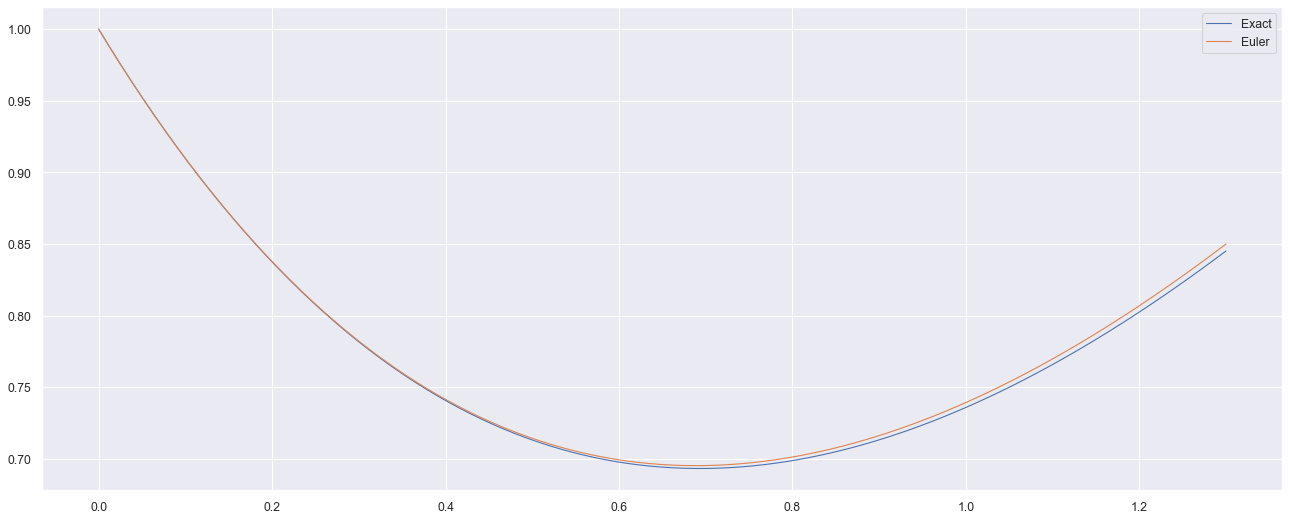

In [20]:
draw(X0, XF, H, ['Exact', 'Euler'], exact_ys, euler_ys)

101 101 0.0 1.0 1.3 0.8450635860680253
101 101 0.0 1 1.3 0.8545206076415173
101 101 0.0 1 1.3 0.8548225804431064
101 101 0.0 1 1.3 0.8545206729279609
101 101 0.0 1 1.3 0.8548225804431064


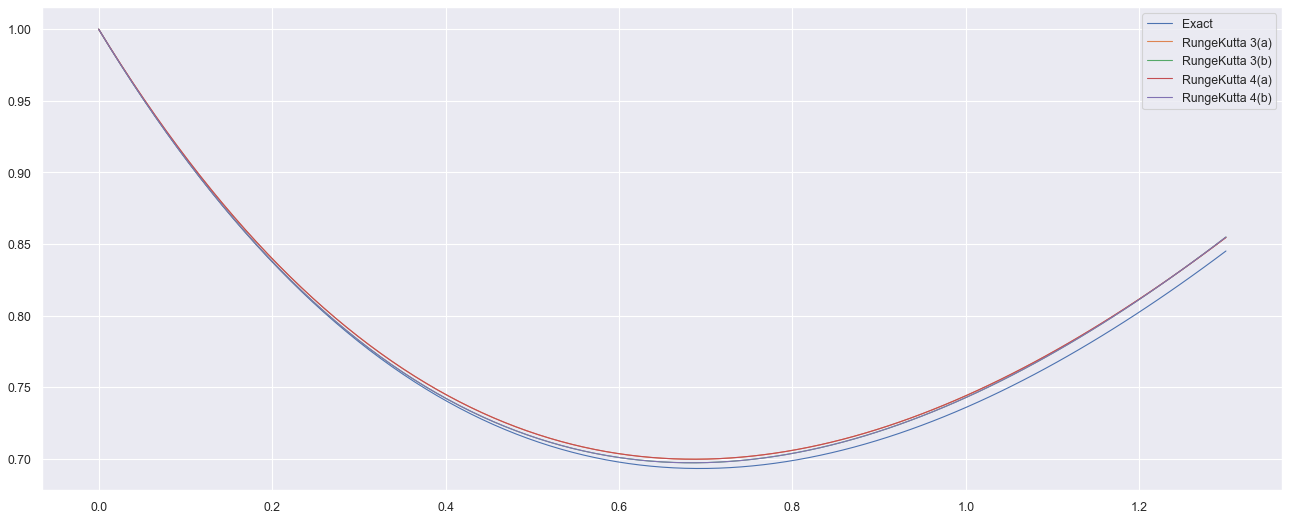

In [21]:
draw(X0, XF, H, ['Exact', 'RungeKutta 3(a)', 'RungeKutta 3(b)', 'RungeKutta 4(a)', 'RungeKutta 4(b)'], exact_ys, rk_ys_3a, rk_ys_3b, rk_ys_4a, rk_ys_3b,)

101 101 0.0 1.0 1.3 0.8450635860680253
101 101 0.0 1 1.3 0.843283854721396
101 101 0.0 1 1.3 0.8499243920594484
101 101 0.0 1 1.3 0.8499243920594484
101 101 0.0 1 1.3 0.8499243920594484


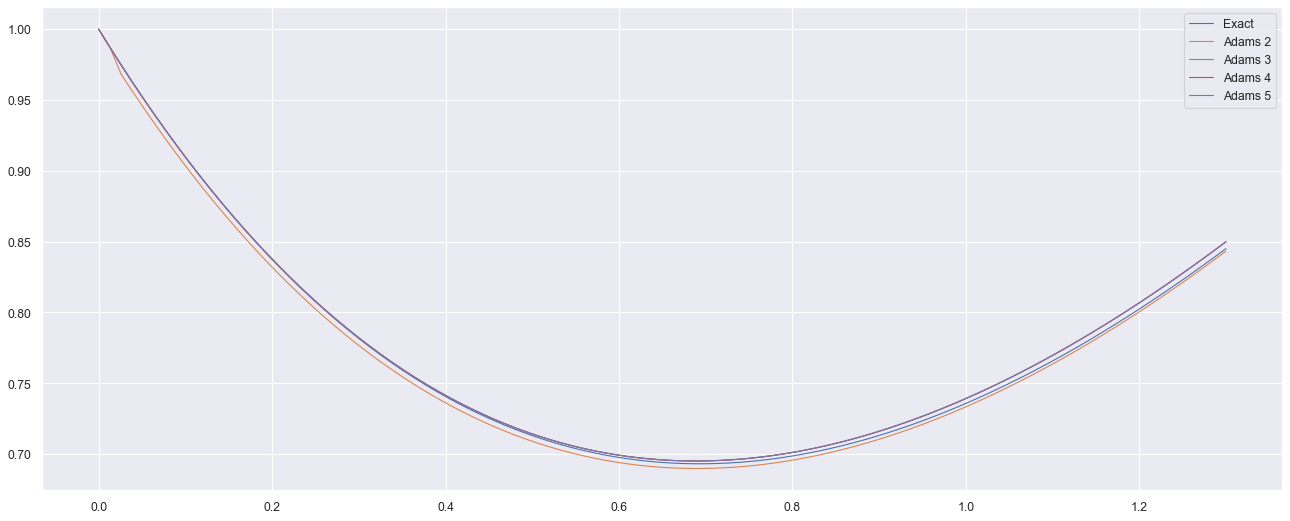

In [22]:
draw(X0, XF, H, ['Exact', 'Adams 2', 'Adams 3', 'Adams 4', 'Adams 5'], exact_ys, adams_ys_2, adams_ys_3, adams_ys_4, adams_ys_5,)

# Задача Коши для систем

In [23]:
def equation_x(x, y, z, t):
    return -2*x + 5*z

def equation_y(x, y, z, t):
    return -(1 - sin(t)*x - y + 3*z)

def equation_z(x, y, z, t):
    return -x + 2*z

In [29]:
N = 1000

X0 = 0
TX0 = 2
XF = 0.3
HX = (XF - X0) / N
XF += HX

Y0 = 0
TY0 = 1
YF = 0.3
HY = (YF - Y0) / N
YF += HY

Z0 = 0
TZ0 = 1
ZF = 0.3
HZ = (ZF - Z0) / N
ZF += HZ

In [30]:
runge_kutta_x = RungeKutta_4a(equation, HX)
rk_ys_x = runge_kutta.calculate(X0, TX0, XF)

runge_kutta_y = RungeKutta_4a(equation, HY)
rk_ys_y = runge_kutta.calculate(Y0, TY0, YF)

runge_kutta_z = RungeKutta_4a(equation, HZ)
rk_ys_z = runge_kutta.calculate(Z0, TZ0, ZF)

In [31]:
data = pd.DataFrame()
data['RungeKutta X'] = rk_ys_x
data['RungeKutta Y'] = rk_ys_y
data['RungeKutta Z'] = rk_ys_z

In [32]:
data.head(10)

,RungeKutta X,RungeKutta Y,RungeKutta Z
0,2.000000,1.000000,1.000000
1,1.974364,0.987308,0.987308
2,1.949229,0.974949,0.974949
3,1.924587,0.962918,0.962918
4,1.900432,0.951212,0.951212
5,1.876758,0.939825,0.939825
6,1.853559,0.928753,0.928753
7,1.830829,0.917994,0.917994
8,1.808561,0.907541,0.907541
9,1.786749,0.897393,0.897393


In [33]:
data.tail(10)

,RungeKutta X,RungeKutta Y,RungeKutta Z
14,1.684335,0.851067,0.851067
15,1.665142,0.842659,0.842659
16,1.646364,0.834528,0.834528
17,1.627999,0.826671,0.826671
18,1.610039,0.819083,0.819083
19,1.592480,0.811762,0.811762
20,1.575316,0.804705,0.804705
21,1.558543,0.797906,0.797906
22,1.542155,0.791364,0.791364
23,1.526148,0.785075,0.785075


# Уравнение теплопроводности

$$
\begin{cases}
    u_t = a^2 u_{xx}, \ \ \ 0 < x < l, \ \ \ 0 < t < T \\
    u(x, 0) = \varphi(x), \ \ \ 0 \leq x \leq l \\
    u(0, t) = \alpha, \ \ \ 0 \leq t \leq T \\
    u(l, t) = \beta, \ \ \ 0 \leq t \leq T \\
\end{cases}
$$

## Решение

$$
\begin{cases}
    u_t = 5 u_{xx}, \ \ \ 0 < x < l, \ \ \ 0 < t < T \\
    u(x, 0) = 6sin(2\pi x) + 13sin(5\pi x), \ \ \ 0 \leq x \leq l \\
    u(0, t) = 0, \ \ \ 0 \leq t \leq T \\
    u(5, t) = 0, \ \ \ 0 \leq t \leq T \\
\end{cases}
$$

### Явная схема

#### Константы

In [28]:
a_2 = 5
T = 1
L = 5

M = 200000
N = 500

delta_t = T/M
delta_x = L/N

alpha = 0
beta = 0

In [29]:
def phi(x):
    return 6*math.sin(2 * math.pi * x) + 13*math.sin(5 * math.pi * x)

In [30]:
#Условие устойчивости явной схемы
D = ((a_2 * delta_t) / (delta_x**2))
if(D > 0.5):
    print("Неустойчиво")

In [31]:
#Вычисление
u_explicit = np.zeros((M + 1, N + 1))
x_explicit = np.arange(0, L + delta_x, delta_x)

for n in range(N + 1):
    u_explicit[0, n] = phi(n*delta_x)
    
for m in range(M + 1):
    u_explicit[m, 0] = alpha
    u_explicit[m, N] = beta
    
for m in range(1, M):
    for n in range(1, N):
        u_explicit[m, n + 1] = u_explicit[m, n] + D * (u_explicit[m + 1, n] - 2 * u_explicit[m, n] + u_explicit[m - 1, n]) 

KeyboardInterrupt: 

In [ ]:
#Отрисовка графика
plt.figure(figsize=(20,8), dpi= 80)
plt.title("Явная схема")
for y in u_explicit:
    plt.plot(x_explicit, y)

### Неявная схема

#### Константы

In [ ]:
a_2 = 5
T = 1
L = 5

M = 10000
N = 10000

delta_t = T/M
delta_x = L/N

rho = a_2 * delta_t / (delta_x**2)

alpha = 0
beta = 0

In [ ]:
def phi(x):
    return 6*math.sin(2 * math.pi * x) + 13*math.sin(5 * math.pi * x)

In [ ]:
def tridiagonal_algo(A, C, B, F):
    n = len(F)
    alf = [0 for i in range(n)]
    bet = [0 for i in range(n)]
    X = [0 for i in range(n)]
    alf[1], bet[1] = -B[0]/C[0], F[0]/C[0]
    
    for i in range(2, n):
        alf[i] = -B[i-1]/(A[i-1]*alf[i-1] + C[i-1])
        bet[i] = (F[i-1] - A[i-1]*bet[i-1])/(A[i-1]*alf[i-1] + C[i-1])
        
    X[n-1] = (F[n-1] - A[n-1]*bet[n-1])/(A[n-1]*alf[n-1] + C[n-1])
    
    for i in reversed(range(n-1)):
        X[i] = alf[i+1]*X[i+1] + bet[i+1]
        
    return X

In [ ]:
#x = linalg.solve(mat_dig, rhs)

In [ ]:
#Вычисление
u_implicit = np.zeros((M + 1, N + 1))
x_implicit = np.arange(0, L + delta_x, delta_x)

for i in range(N + 1):
    u_implicit[0, i] = phi(x_implicit[i])
    
for m in range(M + 1):
    u_implicit[m, 0] = alpha
    u_implicit[m, N] = beta
    
A = np.zeros(N + 1)
B = np.zeros(N + 1)

for m in range(0, M):
    A[1] = 0
    B[1] = alpha
    for j in range(1, N):
        A[j + 1] = D / (1 - (A[j] - 2) * D)
        B[j + 1] = (u_implicit[m, j] + B[j]  * D)/(1 - (A[j] - 2) * D)
    u_implicit[m + 1, N] = B[N] / (1 - A[N])
    for j in range(N - 1, 0, -1):
        u_implicit[m + 1, j] = A[j + 1] * u_implicit[m + 1, j + 1] + B[j + 1]

In [ ]:
#Отрисовка графика
plt.figure(figsize=(20,8), dpi= 80)
plt.title("Неявная схема")
for y in u_implicit:
    plt.plot(x_implicit, y)
plt.show()